<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/main/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup enviroment and imports

## Setup

In [ ]:
import os
import torch

os.environ['TORCH'] = torch.__version__
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
print(torch.__version__)

!pip install -q pyg_lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_geometric -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torcheval
!pip install -q scikit-plot

2.4.0+cu121


## Imports

In [ ]:
import json
import networkx as nx
import torch
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric import nn, sampler
from torch_geometric.data import HeteroData, Data
from torch_geometric import transforms as T
from torch_geometric import loader
from torcheval import metrics
from torcheval.metrics import R2Score, MeanSquaredError
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
from io import BytesIO
from typing import Callable
%matplotlib inline

## Other

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Analizing scraped data and create graph



## Get Zipped test.json file

In [ ]:
with requests.get("https://github.com/JasaZnidar/totalwaterpolo-web-scraper/raw/master/test.zip", ) as r:
  ZipFile(BytesIO(r.content), "r").extractall()

## Get scraped data from github repository

In [ ]:
# open raw data scraped from the website
with open("/content/test.json") as f:
    scraped_data = json.load(f)

## Data generating function
We will create a function that will create HeteroData from scraped data before a selected date. This will be used to create training data.

### player_in_match functions

In [ ]:
def average(history: list[list[float]]) -> list[float]:
  ret = [0]*len(history[0])

  # sum up all values
  for match in history:
    for i in range(len(match)):
      ret[i] += match[i]

  # divide to get average
  if len(history) > 0:
    for i in range(len(ret)):
      ret[i] /= len(history)

  return ret

def average_last_n(history: list[list[float]], n: int = 20) -> list[float]:
  ret = [0]*len(history[0])
  n = min(n, len(history))
  history = history[-n:]

  # sum up all values
  for match in history:
    for i in range(len(match)):
      ret[i] += match[i]

  # divide to get average
  if n > 0:
    for i in range(len(ret)):
      ret[i] /= n

  return ret

def function_weight(history: list[list[float]], f: Callable = lambda x: 1/x) -> list[float]:
  ret = [0]*len(history[0])


  # sum up all values
  n = len(history)
  weight_sum = 0
  for m in range(n):
    weight = f(n-m)
    weight_sum += weight
    for i in range(len(history[m])):
      ret[i] += history[m][i] * weight

  # normalize with weight sum
  if weight_sum > 0:
    for i in range(len(ret)):
      ret[i] /= weight_sum

  return ret

### Graph creation function

In [ ]:
def createData(
    data: dict,
    start: int=0,
    stop: int=-1,
    instanceCalculator: Callable=average,
    combineCalculator: Callable=lambda x: torch.mean(torch.Tensor(x), dim=0)
    ) -> tuple[HeteroData, Data]:
  # data
  ret_hetero_data = HeteroData()
  ret_homogen_data = Data()


  #=============================================================================
  # Create player_matrix for player node
  #=============================================================================
  max_player_id = max([int(id) for id in data['players'].keys()])
  player_dim=5
  player_matrix = torch.zeros(max_player_id, player_dim, dtype=torch.float32)
  all_player_data = {}

  for id in data['players'].keys():
    index = int(id) - 1
    player_data = data['players'][id]
    all_player_data[id] = {
        "history": [],    # [[goals, shots, assists, blocks, saves, exclusions, penalties, suspensions, brutalities, sprints won, sprints],...]
        "last index": -1    # last index, referencing this them in playerInMatch node
    }

    player_matrix[index, 0] = player_data['birth']
    player_matrix[index, 1] = 1 if player_data['hand'] == 'R' else -1 if player_data['hand'] == "L" else 0
    player_matrix[index, 2] = player_data['height'] if player_data['height'] else 0
    match player_data['position']:
      case '':
        player_matrix[index, 3] = 0
      case 'Goalkeeper':
        player_matrix[index, 3] = 1
      case 'Driver':
        player_matrix[index, 3] = 2
      case 'Left Driver':
        player_matrix[index, 3] = 3
      case 'Right Driver':
        player_matrix[index, 3] = 4
      case 'Central Defender':
        player_matrix[index, 3] = 5
      case 'Left Winger':
        player_matrix[index, 3] = 6
      case 'Right Winger':
        player_matrix[index, 3] = 7
      case 'Center Forward':
        player_matrix[index, 3] = 8
    player_matrix[index, 4] = player_data['weight'] if player_data['weight'] else 0

  del player_data, index


  #=============================================================================
  # Matrices that will define the graph
  #=============================================================================
  # player in a match (played_in_match)
  playerInMatch_dim = 11
  playerInMatch_matrix = torch.empty(0, playerInMatch_dim, dtype=torch.float32)

  # team (team)
  numOfTeams = 0

  # team in a match (team_in_match)
  teamInMatch_dim = 3
  teamInMatch_matrix = torch.empty(0, teamInMatch_dim, dtype=torch.float32)

  # player instance relation (player, player_instance, played_in_match)
  playerInstance_matrix = torch.empty(2, 0, dtype=torch.long)

  # played relation (played_in_match, played, team_in_match)
  played_matrix = torch.empty(2, 0, dtype=torch.long)
  played_attr = torch.empty(1, 0, dtype=torch.float32)

  # team participated in a match (team, team_instance, team_in_match)
  teamInstance_matrix = torch.empty(2, 0, dtype=torch.long)

  # match result (team_in_match, result, team_in_match)
  result_matrix = torch.empty(2, 0, dtype=torch.long)
  result_attr = torch.empty(1, 0, dtype=torch.float32)
  # reversed relations
  result_rev_attr = torch.empty(1, 0, dtype=torch.float32)

  homogen_node_dim = playerInMatch_dim
  homogen_node_matrix = torch.empty(0, homogen_node_dim, dtype=torch.float32)

  homogen_edge_matrix = torch.empty(2, 0, dtype=torch.long)
  homogen_edge_attr = torch.empty(1, 0, dtype=torch.float32)


  #=============================================================================
  # Other data
  #=============================================================================
  all_team_data = {}   # key => {data, last_index, index}


  #=============================================================================
  # Sort matches in order of date, and filter out the matches that happened
  # after the specified date
  #=============================================================================
  # filter out matches
  sorted_match_ids = []
  breakpoint_match_id = ("", -1)
  for match_id in data['matches']:
    if 'date' in data['matches'][match_id]:
      sorted_match_ids.append((match_id, data['matches'][match_id]['date']))

  # sort matches
  sorted_match_ids = sorted(sorted_match_ids, key=lambda t: t[1])


  #=============================================================================
  # Loop through the matches and fill out the matrices
  #=============================================================================
  for index in range(len(sorted_match_ids)):
    # exit loop if enough matches have been added
    if result_matrix.shape[1] == stop - start:
      break
    match_id, _ = sorted_match_ids[index]
    match_data = data['matches'][match_id]

    # check if match is relevant (at least 7 players in each team)
    if len(match_data['lineup']['home']) < 7 or len(match_data['lineup']['away']) < 7:
      continue


    #===========================================================================
    # result of match
    #===========================================================================
    if index >= start:
      result_matrix = torch.cat((result_matrix, torch.empty((2, 1))), dim=1)
      result_attr = torch.cat((result_attr, torch.empty((1, 1))), dim=1)
      result_rev_attr = torch.cat((result_rev_attr, torch.empty((1, 1))), dim=1)
      if match_data['result']['home'] > match_data['result']['away']:
        result_attr[0, -1] = 1.0
        result_rev_attr[0, -1] = 0.0
      elif match_data['result']['home'] < match_data['result']['away']:
        result_attr[0, -1] = 0.0
        result_rev_attr[0, -1] = 1.0
      else:
        result_attr[0, -1] = 0.5
        result_rev_attr[0, -1] = 0.5


    #===========================================================================
    # loop through the teams
    #===========================================================================
    for team in ['home', 'away']:
      # create teamInMatch
      team_key = match_data['name'][team]

      #=========================================================================
      # create/update all_team_data
      #=========================================================================
      # if there is no instance of the team, we need a new team
      if not team_key in all_team_data:
        all_team_data[team_key] = {
            "data": [0]*teamInMatch_dim,    # [wins, matches, home/away]
            "last index": -1,   # last index, referencing this them in teamInMatch node
            "index": numOfTeams   # index for team node
        }

        # add new team
        numOfTeams += 1

      # update home/away status
      all_team_data[team_key]['data'][-1] = 0 if team == "home" else 1


      #=========================================================================
      # create team_in_match data instance
      #=========================================================================
      if index >= start:
        # add new teamInMatch
        all_team_data[team_key]['last index'] = teamInMatch_matrix.size(dim=0)
        teamInMatch_matrix = torch.cat((teamInMatch_matrix, torch.Tensor([all_team_data[team_key]['data']])), dim=0)

        # connect teamInMatch to enemy teamInMatch
        result_matrix[0 if team == "home" else 1, -1] = all_team_data[team_key]['last index']

        # connect team to teamInMatch
        teamInstance_matrix = torch.cat((teamInstance_matrix, torch.Tensor([[all_team_data[team_key]['index']], [all_team_data[team_key]['last index']]])), dim=1)


      #=========================================================================
      # update all_team_data
      #=========================================================================
      # if won, increase number of wins
      if match_data['result'][team] > match_data['result']['away' if team == "home" else 'home']:
        all_team_data[team_key]['data'][0] += 1

      # increase number of matches
      all_team_data[team_key]['data'][1] += 1


      #=========================================================================
      # loop through the lineup
      #=========================================================================
      for player_num in match_data['lineup'][team]:
        player_id = match_data['lineup'][team][player_num]['id']


        #=======================================================================
        # add and connect new nodes together
        #=======================================================================
        if index >= start:
          # add new playerInMatch
          if not player_id in all_player_data:
            all_player_data[player_id] = {
                "history": [],
                "last index": -1
            }
          if all_player_data[player_id]['history'] == []:
            playerInMatch_tensor = torch.Tensor([[0]*playerInMatch_dim])
          else:
            playerInMatch_tensor = torch.Tensor([ instanceCalculator( all_player_data[player_id]['history'] ) ])
          all_player_data[player_id]['last index'] = playerInMatch_matrix.size(dim=0)
          playerInMatch_matrix = torch.cat((playerInMatch_matrix, playerInMatch_tensor), dim=0)
          playerInMatch_index = playerInMatch_matrix.size(dim=0) - 1

          # connect player to playerInMatch
          playerInstance_matrix = torch.cat((playerInstance_matrix, torch.Tensor([[int(player_id)-1], [all_player_data[player_id]['last index']]])), dim=1)

          # connect playerInMatch to teamInMatch
          played_matrix = torch.cat((played_matrix, torch.Tensor([[all_player_data[player_id]['last index']], [all_team_data[team_key]['last index']]])), dim=1)
          played_attr = torch.cat((played_attr, torch.Tensor([[0 if player_num == "1" or player_num == "13" else 1]])), dim=1)

        # add all_player_data history for this match
        all_player_data[player_id]['history'].append([0] * playerInMatch_dim)


    #===========================================================================
    # update data with this match
    #===========================================================================
    # go throught ALL plays and update cumulative_all_player_data and cumulative_all_team_data
    for play in match_data['plays']:
      # check if a player was marked
      if play['player_1'] == 0:
        continue

      # find teams
      team_1 = play['team']
      team_2 = "home" if team_1 == "away" else "away"

      # find players who participated in the play
      try:
        id_1 = match_data['lineup'][team_1][str(play['player_1'])]['id']
      except Exception as ex:
        print(match_id, team_1, match_data['name'][team_1])
        #print(json.dumps(match_data['lineup'][team_1], sort_keys=True, indent=4))
        print(json.dumps(play, sort_keys=True, indent=4))
        raise ex
      id_2 = [0, 0] # depending on the play, the second player could be from the same team (first value is the opposing team)
      if not play['player_2'] == 0:
        if str(play['player_2']) in match_data['lineup'][team_2]:
          id_2[0] = match_data['lineup'][team_2][str(play['player_2'])]['id']
        if str(play['player_2']) in match_data['lineup'][team_1]:
          id_2[1] = match_data['lineup'][team_1][str(play['player_2'])]['id']

      # detect play type
      if "goal scored" in play['action']:
        # goals
        all_player_data[id_1]['history'][-1][0] += 1
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
        if not id_2[1] == 0:
          # assists
          all_player_data[id_1]['history'][-1][2] += 1
      elif "exclusion" in play['action']:
        # exclusion
        all_player_data[id_1]['history'][-1][5] += 1
      elif "penalty foul" in play['action']:
        # penalty
        all_player_data[id_1]['history'][-1][6] += 1
      elif "shot missed" in play['action']:
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
      elif "shot saved" in play['action']:
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
      elif "shot blocked" in play['action']:
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
        if not id_2[0] == 0:
          # blocks
          all_player_data[id_2]['history'][-1][3] += 1
      elif "suspention" in play['action']:
        # suspensions
        all_player_data[id_1]['history'][-1][7] += 1
      elif "brutality" in play['action']:
        # brutalities
        all_player_data[id_1]['history'][-1][8] += 1
      elif "sprint won" in play['action']:
        # sprint won
        all_player_data[id_1]['history'][-1][9] += 1
        # sprint
        all_player_data[id_1]['history'][-1][10] += 1
        if not id_2[0] == 0:
          # sprint
          all_player_data[id_2]['history'][-1][10] += 1


  #=============================================================================
  # save heterogeneus data
  #=============================================================================
  ret_hetero_data['player'].x = player_matrix
  ret_hetero_data['player_in_match'].x = playerInMatch_matrix
  ret_hetero_data['team'].num_nodes = numOfTeams
  ret_hetero_data['team_in_match'].x = teamInMatch_matrix

  ret_hetero_data['player', 'player_instance', 'player_in_match'].edge_index = playerInstance_matrix.type(torch.long)
  ret_hetero_data['player_in_match', 'player_instance_rev', 'player'].edge_index = playerInstance_matrix.flip([0]).type(torch.long)

  ret_hetero_data['player_in_match', 'played', 'team_in_match'].edge_index = played_matrix.type(torch.long)
  ret_hetero_data['player_in_match', 'played', 'team_in_match'].edge_attr = played_attr
  ret_hetero_data['team_in_match', 'played_rev', 'player_in_match'].edge_index = played_matrix.flip([0]).type(torch.long)
  ret_hetero_data['team_in_match', 'played_rev', 'player_in_match'].edge_attr = played_attr

  ret_hetero_data['team', 'team_instance', 'team_in_match'].edge_index = teamInstance_matrix.type(torch.long)
  ret_hetero_data['team_in_match', 'team_instance_rev', 'team'].edge_index = teamInstance_matrix.flip([0]).type(torch.long)

  ret_hetero_data['team_in_match', 'result', 'team_in_match'].edge_index = result_matrix.type(torch.long)
  ret_hetero_data['team_in_match', 'result', 'team_in_match'].edge_attr = result_attr
  ret_hetero_data['team_in_match', 'result_rev', 'team_in_match'].edge_index = result_matrix.flip([0]).type(torch.long)
  ret_hetero_data['team_in_match', 'result_rev', 'team_in_match'].edge_attr = result_rev_attr


  #=============================================================================
  # create homogeneus data from heterogeneus data
  #=============================================================================
  """teams = [all_team_data[team] for team in all_team_data.keys()]
  sorted_teams = sorted(teams, key=lambda x: x['index'])

  # get playerInMatch data to combine using 'last index' in sorted_teams
  for team in sorted_teams:
    players = []

    # get playerInMatch data index
    for i in range(played_matrix.shape[1]):
      if played_matrix[1, i] == team['last index']:
        players.append(i)

    # extract playerInMatch data
    players_data = torch.zeros((len(players), playerInMatch_dim), dtype=torch.float32)
    for i, id in enumerate(players):
      players_data[i, :] = playerInMatch_matrix[id, :]

    # calculate combination and add to matrix
    combine = combineCalculator(players_data).reshape((1, playerInMatch_dim))
    homogen_node_matrix = torch.cat((homogen_node_matrix, combine), dim=0)

  # loop through the matches again to add match results
  for index in range(len(sorted_match_ids)):
    # exit loop if enough matches have been added
    if homogen_edge_matrix.shape[1] == stop - start:
      break
    match_id, _ = sorted_match_ids[index]
    match_data = data['matches'][match_id]
    if not match_data['name']['home'] in all_team_data:
      home_index = homogen_node_matrix.shape[0] - 1
      homogen_node_matrix = torch.cat((homogen_node_matrix, torch.zeros((1, playerInMatch_dim))), dim=0)
    else:
      home_index = all_team_data[match_data['name']['home']]['index']
    if not match_data['name']['away'] in all_team_data:
      away_index = homogen_node_matrix.shape[0] - 1
      homogen_node_matrix = torch.cat((homogen_node_matrix, torch.zeros((1, playerInMatch_dim))), dim=0)
    else:
      away_index = all_team_data[match_data['name']['away']]['index']
    home_result = match_data['result']['home']
    away_result = match_data['result']['away']

    homogen_edge_matrix = torch.cat((homogen_edge_matrix, torch.Tensor([[home_index], [away_index]])), dim=1)
    homogen_edge_attr = torch.cat((homogen_edge_attr, torch.Tensor([[home_result - away_result]])), dim=1)
    homogen_edge_matrix = torch.cat((homogen_edge_matrix, torch.Tensor([[away_index], [home_index]])), dim=1)
    homogen_edge_attr = torch.cat((homogen_edge_attr, torch.Tensor([[away_result - home_result]])), dim=1)

  ret_homogen_data.x = homogen_node_matrix.to(torch.float32)
  ret_homogen_data.edge_index = homogen_edge_matrix.to(torch.long)
  ret_homogen_data.edge_attr = homogen_edge_attr.to(torch.float32)"""

  return ret_hetero_data, ret_homogen_data

def numberOfValidMatches(data: dict) -> int:
  numOfMatches = 0
  for match_id in data['matches']:
    if len(data['matches'][match_id]['lineup']['home']) < 7 or len(data['matches'][match_id]['lineup']['away']) < 7:
      continue
    numOfMatches += 1

  return numOfMatches

### Split data into training and validation

Values to define the scope of the training and validation.

In [ ]:
training = -1
validate = 1000
instance_function = average
combination_function = lambda x: torch.mean(torch.Tensor(x), dim=0)

If train or validate are not bigger then 0, their values are addapted acordingly to fully utilize the avaliable data.

In [ ]:
numOfMatches = numberOfValidMatches(scraped_data)
if training <= 0 and validate <= 0:
  validate = 1
  training = numOfMatches - 1
elif training <= 0:
  training = numOfMatches - validate
elif validate <= 0:
  validate = numOfMatches - training

print(f"train: 0 - {training-1}")
print(f"validate: {training} - {training + validate}")


train: 0 - 3383
validate: 3384 - 4384


In [ ]:
hetero_train_data, homo_train_data = createData(scraped_data, stop=training, instanceCalculator=instance_function, combineCalculator=combination_function)
hetero_val_data, homo_val_data = createData(scraped_data, start=training, stop=(training + validate), instanceCalculator=instance_function, combineCalculator=combination_function)

# Machine learning

## Setup

In [ ]:
epochs = 100
size = 32
iterations = 3
embedding_size = 20
lr = 0.001
metapath = [('team_in_match', 'played_rev', 'player_in_match'), ('player_in_match', 'player_instance_rev', 'player'), ('player', 'player_instance', 'player_in_match')]

## Classifier

In [ ]:
class Classifier(torch.nn.Module):
    def forward(self, x_match: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_winner = x_match[edge_label_index[0]]
        edge_feat_loser = x_match[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_winner * edge_feat_loser).sum(dim=-1)

## Embedding

In [ ]:
class Embedding(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.vec = torch.nn.MetaPath2Vec(
            edge_index_dict = {edge : hetero_train_data[edge].edge_index for edge in hetero_train_data.metadata()[1]},
            embedding_dim = embedding_size,
            metapath = metapath,
            walk_length = 20,
            context_size = 10,
            walks_per_node = 20
        )

    def forward(self, x_match: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_winner = x_match[edge_label_index[0]]

## Metrics

In [ ]:
regresionMetrics = [metrics.R2Score, metrics.MeanSquaredError]
classificationMetrics = []#[metrics.AUC]

class Metrics:
  def __init__(self, device: str = 'cpu', regresion: list[Callable] = regresionMetrics, classification: list[Callable] = classificationMetrics):
    self.device = device
    self.regresion = [r().to(device) for r in regresion]
    self.classification = [c().to(device) for c in classification]

  def regToClass(self, pred: torch.Tensor, ground_truth: torch.Tensor, values: torch.Tensor = torch.Tensor([0.0, 0.5, 1.0])) -> torch.Tensor:
    pred = pred.to(self.device)
    ground_truth = ground_truth.to(self.device)
    values = values.to(self.device)

    length = pred.shape[0]
    ret = torch.empty(length, dtype=torch.long)

    for i in range(length):
      diff = values - pred[i]
      ret[i] = 1.0 if values[torch.argmin(torch.abs(diff))] == ground_truth[i] else 0.0

    return ret

  def update(self, pred: torch.Tensor, ground_truth: torch.Tensor):
    pred = pred.to(self.device)
    ground_truth = ground_truth.to(self.device)

    for metric in self.regresion:
      metric.update(pred, ground_truth)

    class_pred = self.regToClass(pred, ground_truth)
    for metric in self.classification:
      metric.update(class_pred, torch.ones(class_pred.shape, dtype=torch.long))

  def compute(self):
    ret = {}

    for metric in self.regresion:
      ret[metric.__class__.__name__] = metric.compute()

    for metric in self.classification:
      ret[metric.__class__.__name__] = metric.compute()

    return ret


In [ ]:
def drawData(data: list[dict]) -> None:
  keys = [key for key in data[0].keys()]
  num = len(keys)

  _, ax = plt.subplots(1, num, figsize=(num*3, 4))

  for i in range(num):
    ax[i].set_title(keys[i])

    ax[i].plot(range(len(data)), [data[x][keys[i]].item() for x in range(len(data))])

  plt.show()


## Encoder and Decoder

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, layer=nn.GATConv, device='cpu'):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.convs.append(layer(in_channels, hidden_channels))
    for _ in range(1, layers-1):
      self.convs.append(layer(hidden_channels, hidden_channels))
    self.convs.append(layer(hidden_channels, out_channels))

  def forward(self, x, edge_index):
    for conv in self.convs[:-1]:
      x = conv(x, edge_index)
      x = x.relu()
    x = self.convs[-1](x, edge_index)

    return x

  def forward(self, x, edge_index):
    for conv in self.convs[:-1]:
      x = conv(x, edge_index)
      x = x.relu()
    x = self.convs[-1](x, edge_index)

    return x

class Decoder(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2):
    super().__init__()

    self.lins = torch.nn.ModuleList()
    self.lins.append(nn.Linear(in_channels, hidden_channels))
    for _ in range(1, layers-1):
      self.lins.append(nn.Linear(hidden_channels, hidden_channels))
    self.lins.append(nn.Linear(hidden_channels, out_channels))

  def forward(self, x_dict, edge_label_index):
    row, col = edge_label_index
    x = torch.cat([x_dict['team'][row], x_dict['team'][col]], dim=-1)

    for lin in self.lins[:-1]:
      x = lin(x)
      x = x.relu()
    x = self.lins[-1](x)

    return x

## Basic module

In [ ]:
class basicModule(torch.nn.Module):
  def __init__(self, device='cpu'):
    super().__init__()
    self.device = device

    self.lin = torch.nn.Linear(2, 1).to(self.device)

  def forward(self, edge, edge_index):
    x = torch.zeros([edge_index.shape[1], 2])
    x[:, 0] = edge[edge_index[0], 2]
    x[:, 1] = edge[edge_index[1], 2]

    x = self.lin(x.to(self.device))

    return x

## Linear module

In [ ]:
class linearModule(torch.nn.Module):
  def __init__(self, in_channels, device='cpu'):
    super().__init__()
    self.device = device

    self.lin = torch.nn.Linear(in_channels, 1).to(self.device)

  def forward(self, x):

    x = self.lin(x.to(self.device))

    return x

# Average data for team based on players in the team
def getTeamAverage(played_dict: dict[int, list[int]], player_data: torch.tensor, teamInMatch_index: int):
  # get all playerInMatch indexes
  playerInMatch_list = played_dict[teamInMatch_index]

  # get all playerInMatch data
  playerInMatch_data = torch.empty((0, player_data.shape[1]), dtype=player_data.dtype)
  for i in playerInMatch_list:
    playerInMatch_data = torch.cat((playerInMatch_data, torch.unsqueeze(player_data[i, :], dim=0)))
  #torch.Tensor([player_data[i] for i in playerInMatch_list])

  playerInMtach_avg = torch.mean(playerInMatch_data, dim=0)

  return playerInMtach_avg

# create input data
def createLinInput(data: HeteroData):
  data = data.to('cpu')

  # create dict for players in a match
  played_dict = {}
  for i in range(data['player_in_match', 'played', 'team_in_match'].edge_index.shape[1]):
    key = data['player_in_match', 'played', 'team_in_match'].edge_index[1, i].item()
    value = data['player_in_match', 'played', 'team_in_match'].edge_index[0, i].item()
    if key in played_dict:
      played_dict[key].append(value)
    else:
      played_dict[key] = [value]

  # prepare input
  home_x = []
  numOfMatches = data['team_in_match', 'result', 'team_in_match'].edge_index.shape[1]
  home_x = torch.empty((numOfMatches, data['player_in_match'].x.shape[1]))
  away_x = torch.empty((numOfMatches, data['player_in_match'].x.shape[1]))
  for i in range(numOfMatches):
    home_x[i, :] = getTeamAverage(played_dict, data['player_in_match'].x, data['team_in_match', 'result', 'team_in_match'].edge_index[0, i].item())
    away_x[i, :] = getTeamAverage(played_dict, data['player_in_match'].x, data['team_in_match', 'result', 'team_in_match'].edge_index[1, i].item())

  # finalize input
  input = torch.cat((home_x, away_x), dim=1)

  return input.to(device)

## GCN module

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    if layers == 1:
      self.gcn = nn.GCNConv(in_channels, out_channels, add_self_loops=False)
    else:
      self.gcn = torch.nn.ModuleList()
      self.gcn.append(nn.GCNConv(in_channels, hidden_channels, add_self_loops=False))
      for _ in range(1, layers-1):
        self.gcn.append(nn.GCNConv(hidden_channels, hidden_channels, add_self_loops=False))
      self.gcn.append(nn.GCNConv(hidden_channels, out_channels, add_self_loops=False))

    self.gcn.to(self.device)

  def forward(self, x, edge_index):
    x.to(self.device)

    for module in self.gcn:
      x = module(x, edge_index)
      x = x.relu()

    return x

class heteroGCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.gcn = GCN(in_channels, hidden_channels, out_channels, layers, device).to(self.device)

    self.classifier = Classifier().to(self.device)

  def forward(self, data: HeteroData):
    data = data.to(self.device)

    #x_dict = {
    #    "team_in_match": data["team_in_match"].x
    #}
    #edge_index_dict = {edge_label: data[edge_label].edge_index for edge_label in data.metadata()[1]}

    x = self.gcn(data["team_in_match"].x, data["team_in_match", "result", "team_in_match"].edge_index)

    x = self.classifier(x, data["team_in_match", "result", "team_in_match"].edge_index)

    return torch.reshape(x, (1, -1))

## GAT Module

In [ ]:
class GAT(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    if layers == 1:
      self.gat = nn.GATConv(in_channels, out_channels, add_self_loops=False)
    else:
      self.gat = torch.nn.ModuleList()
      self.gat.append(nn.GATConv(in_channels, hidden_channels, add_self_loops=False))
      for _ in range(1, layers-1):
        self.gat.append(nn.GATConv(hidden_channels, hidden_channels, add_self_loops=False))
      self.gat.append(nn.GATConv(hidden_channels, out_channels, add_self_loops=False))

    self.gat.to(self.device)

  def forward(self, x, edge_index, edge_attr):
    x.to(self.device)

    for module in self.gat:
      x = module(x, edge_index, edge_attr)
      x = x.relu()

    return x

class heteroGAT(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.gat = GAT(in_channels, hidden_channels, out_channels, layers, device).to(self.device)

    self.classifier = Classifier().to(self.device)

  def forward(self, data: HeteroData):
    data = data.to(self.device)

    #x_dict = {
    #    "team_in_match": data["team_in_match"].x
    #}
    #edge_index_dict = {edge_label: data[edge_label].edge_index for edge_label in data.metadata()[1]}

    x = self.gat(data["team_in_match"].x, data["team_in_match", "result", "team_in_match"].edge_index, data["team_in_match", "result", "team_in_match"].edge_attr)

    x = self.classifier(x, data["team_in_match", "result", "team_in_match"].edge_index)

    return torch.reshape(x, (1, -1))

## SAGE module

In [ ]:
class SAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    if layers == 1:
      self.gcn = nn.SAGEConv(in_channels, out_channels, add_self_loops=False)
    else:
      self.gcn = torch.nn.ModuleList()
      self.gcn.append(nn.SAGEConv(in_channels, hidden_channels, add_self_loops=False))
      for _ in range(1, layers-1):
        self.gcn.append(nn.SAGEConv(hidden_channels, hidden_channels, add_self_loops=False))
      self.gcn.append(nn.SAGEConv(hidden_channels, out_channels, add_self_loops=False))

  def forward(self, x, edge_index):
    for module in self.gcn:
      x = module(x, edge_index)
      x = x.relu()

    return x

## Training

### Basic Module

R2Score: -3.1605000495910645
MeanSquaredError: 1.007746934890747


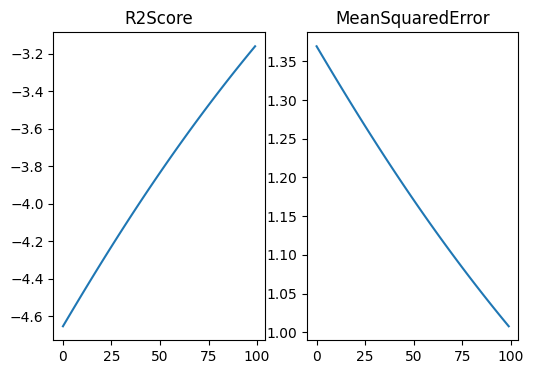

In [ ]:
basic = basicModule(device=device)
basicData = []

optimizer = torch.optim.Adam(basic.parameters(), lr=lr)

for epoch in range(epochs):
  total_loss = total_examples = 0
  basic.train()
  optimizer.zero_grad()
  pred = basic(
      hetero_train_data['team_in_match'].x,
      hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_index
  ).T.to(device)
  ground_truth = hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)
  loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  pred = basic(
      hetero_val_data['team_in_match'].x,
      hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_index
  ).T.to(device)
  ground_truth = hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)

  basicMetric = Metrics(device)
  basicMetric.update(pred.T, ground_truth.T)
  compute = basicMetric.compute()
  basicData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(basicData)

### Linear Module

R2Score: -3.1605000495910645
MeanSquaredError: 1.007746934890747


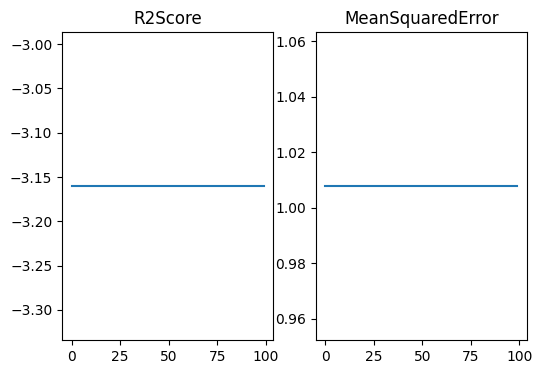

In [ ]:
inputForLinear = createLinInput(hetero_train_data)
linearData = []

linear = linearModule(inputForLinear.shape[1], device=device) # 2*playerInMatch_dim

optimizer = torch.optim.Adam(linear.parameters(), lr=lr)

for epoch in range(epochs):
  total_loss = total_examples = 0
  linear.train()
  optimizer.zero_grad()
  pred = linear(
      inputForLinear
  ).T.to(device)
  ground_truth = hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)
  loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  pred = basic(
      hetero_val_data['team_in_match'].x,
      hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_index
  ).T.to(device)
  ground_truth = hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)

  linearMetric = Metrics(device)
  linearMetric.update(pred.T, ground_truth.T)
  compute = linearMetric.compute()
  linearData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(linearData)

### GCN

R2Score: -1.3109371662139893
MeanSquaredError: 0.5597500205039978


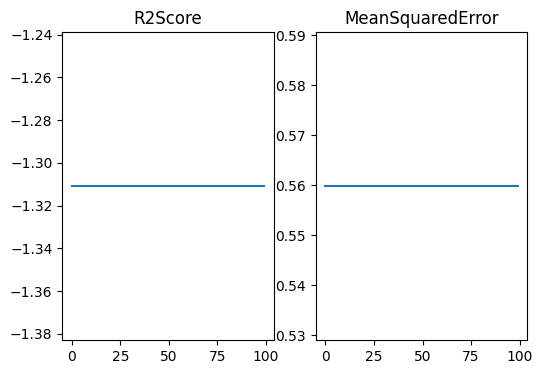

In [ ]:
GCNModule = heteroGCN(hetero_train_data['team_in_match'].x.shape[1], 20, 10, layers=3, device=device)
gcnData = []

optimizer = torch.optim.Adam(GCNModule.parameters(), lr=lr)

#gcnLoader = generateHeteroLoader(hetero_train_data)
#batches = [batch for batch in gcnLoader]

for epoch in range(epochs):
  total_loss = total_examples = 0
  optimizer.zero_grad()

  pred = GCNModule(hetero_train_data).to(device)
  ground_truth = hetero_train_data["team_in_match", "result", "team_in_match"].edge_attr.to(device)
  loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  pred = GCNModule(hetero_val_data).to(device)
  ground_truth = hetero_val_data["team_in_match", "result", "team_in_match"].edge_attr.to(device)

  gcnMetric = Metrics(device)
  gcnMetric.update(pred.T, ground_truth.T)
  compute = gcnMetric.compute()
  gcnData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(gcnData)

### GAT

R2Score: -1.3109371662139893
MeanSquaredError: 0.5597500205039978


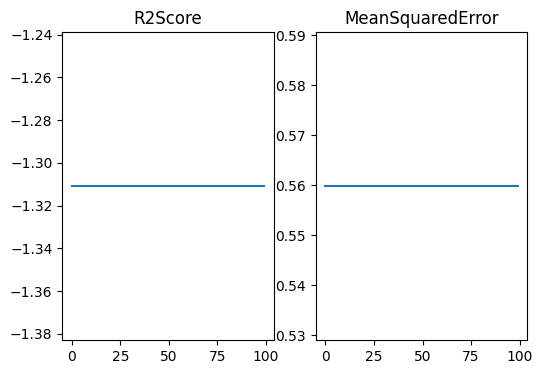

In [ ]:
GATModule = heteroGAT(hetero_train_data['team_in_match'].x.shape[1], 20, 10, layers=3, device=device)
gatData = []

optimizer = torch.optim.Adam(GATModule.parameters(), lr=lr)

for epoch in range(epochs):
  for i in range(training):
    total_loss = total_examples = 0
    optimizer.zero_grad()
    pred = GATModule(hetero_train_data)
    ground_truth = hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_attr
    loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, ground_truth)
    loss.backward()
    optimizer.step()

  # validate
  pred = GCNModule(hetero_val_data).to(device)
  ground_truth = hetero_val_data["team_in_match", "result", "team_in_match"].edge_attr.to(device)

  gatMetric = Metrics(device)
  gatMetric.update(pred.T, ground_truth.T)
  compute = gatMetric.compute()
  gatData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(gatData)